# Initialization

In [1]:
import json
import os
from statistics import mean, median
from data_parser import DataParser
%matplotlib inline
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import numpy as np

In [2]:
IKEA_APP = "annotated-data-sets/ikea-app"
IKEA_APP_ANOMALY = "dev-annotated-datasets/ikea-app/anomaly"
IKEA_HOMEKIT = "annotated-data-sets/ikea-homekit"
IKEA_HOMEKIT_ANOMALY = "dev-annotated-datasets/ikea-homekit/anomaly"
IP_CAM = "annotated-data-sets/ipcam"
IP_CAM_CON = "annotated-data-sets/ipcam+anomaly"
IP_CAM_ANOMALY = "dev-annotated-datasets/ipcam/anomaly"
NORMAL_USER = "annotated-data-sets/normal-user"
NORMAL_USER_ANOMALY = "dev-annotated-datasets/normal-user/anomaly"
VOICE_ASSISTANT = "annotated-data-sets/voice-assistant"
VOICE_ASSISTANT_ANOMALY = "dev-annotated-datasets/voice-assistant/anomaly"
PROCESS_DATASETS = [VOICE_ASSISTANT] # Select datasets
FIND_VALUE = ["Membership Report Group"] # Show flows just with these labels
SKIP_VALUES = ["Flow Error","Local Client Communication","Local Client TCP Scan"] # Skip flows with this labels
ENABLE_FILTER = True # Enable/Disable FIND VALUE filter

DATASET: annotated-data-sets/voice-assistant 25
+----------------+------------+-----------+--------------------+------------+
|      NAME      |    MIN     |    MAX    |        MEAN        |   MEDIAN   |
+----------------+------------+-----------+--------------------+------------+
|      WHT1      |   63.75    |   159.38  |      109.1202      |   127.5    |
|      WHT2      |  -8.0312   |   32.125  |      8.245424      |     0      |
|      WHT3      |  -30.375   |   6.9062  |     -8.015972      |   -2.25    |
|      WHT4      |  -30.625   |    61.5   |      12.10736      |    1.5     |
| Byte_dist_mean |   63.75    |  159.375  |    109.11875004    |   127.5    |
| Byte_dist_std  | 104.080418 | 125.05306 | 116.58493883999999 | 119.492336 |
|    Entropy     |  2.405639  |  2.99148  |     2.61168728     |    2.5     |
|    Pkts_in     |     0      |     0     |         0          |     0      |
|    Pkts_out    |     1      |     3     |        1.48        |     1      |
|    Bytes_in   

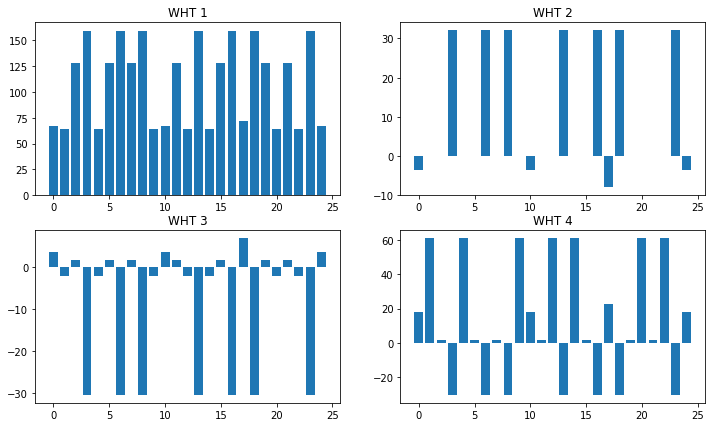

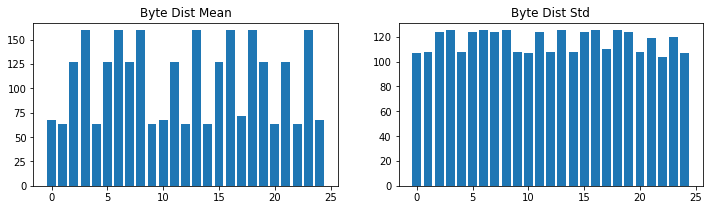

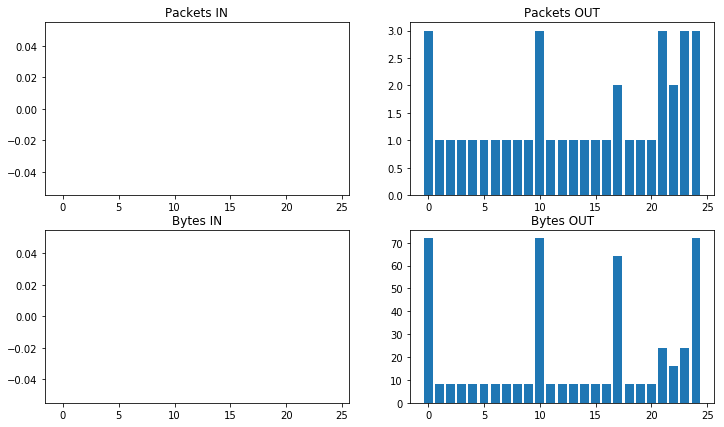

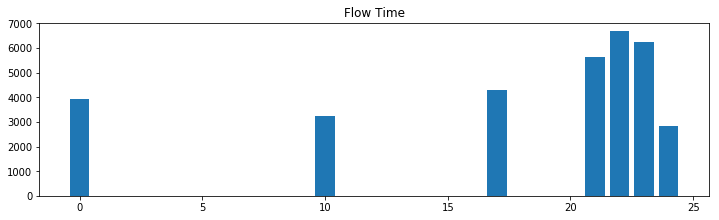

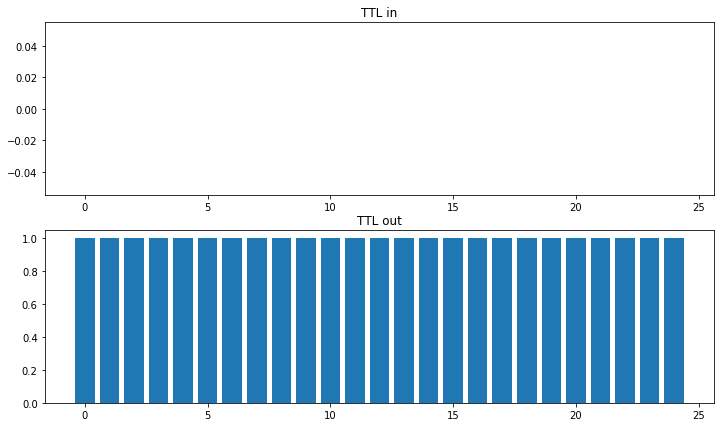

In [3]:
# Scalar Features
wht1 = []
wht2 = []
wht3 = []
wht4 = []
entropy = []
byte_dist_std = []
byte_dist_mean = []
pkts_in = []
pkts_out = []
bytes_in = []
bytes_out = []
flow_time = []
ttl_in = []
ttl_out = []
src_port = set()
dst_port = set()
total_len = 0
data = [] 

for dataset in PROCESS_DATASETS:
    for root, dirs, files in os.walk(dataset):
        if dirs:
            continue
        for file in files:
            # Get values from raw flows
            dParse = DataParser(root+"/"+file,analyse=1,compact=1)
            tmp = dParse.getIndividualFlowMetadata(PKTS=1, BYTES=1, FLOW_TIME=1, WHT=1, BYTE_DIST_M=1, BYTE_DIST_S=1, ENTROPY=1, IDP=1)
            with open(root+"/"+file,encoding="utf-8", mode="r") as flows:
                index = 0 
                for flow in flows:
                    flowData = json.loads(flow)
                    if (flowData["flow_type"] not in FIND_VALUE and ENABLE_FILTER) or flowData["flow_type"] in SKIP_VALUES: # Annotated class name
                        # If flow type is different -> move also feature index
                        index += 1
                        continue
                    # Count number of flows for the specific "dataset"
                    total_len += 1
                
                    # Add WHT
                    if "wht" in flowData:
                        whtFields = list(flowData["wht"])
                        wht1.append(whtFields[0])
                        wht2.append(whtFields[1])
                        wht3.append(whtFields[2])
                        wht4.append(whtFields[3])
                    else:
                        wht1.append(0)
                        wht2.append(0)
                        wht3.append(0)
                        wht4.append(0)
                    # Add Byte_dist_std
                    if "byte_dist_std" in flowData:
                        byte_dist_std.append(flowData["byte_dist_std"])
                    else:
                        byte_dist_std.append(0)
                    # Add byte_dist_mean
                    if "byte_dist_mean" in flowData:
                        byte_dist_mean.append(flowData["byte_dist_mean"])
                    else:
                        byte_dist_mean.append(0)
                    # Add entropy
                    if "entropy" in flowData:
                        entropy.append(flowData["entropy"])
                    else:
                        entropy.append(0)
                    # total_entropy -> doesn't make any sense -> reduced value is the same as entropy
                    # Add TTL
                    try:
                        ttl_in.append(flowData["ip"]["in"]["ttl"])
                    except Exception as e:
                        ttl_in.append(0)
                    try:
                        ttl_out.append(flowData["ip"]["out"]["ttl"])
                    except Exception as e:
                        ttl_out.append(0)

                    #Add preprocessed features
                    #These features are always in the extended flow record
                    pkts_in.append(tmp[index][0])
                    pkts_out.append(tmp[index][1])
                    bytes_in.append(tmp[index][2])
                    bytes_out.append(tmp[index][3])
                    flow_time.append(tmp[index][4])
                    src_port.add(flowData["sp"])
                    dst_port.add(flowData["dp"])
                    index += 1
                    #except Exception as e:
                    #    pass
                    
    print("DATASET:", dataset, total_len)  
    table = PrettyTable()
    table.field_names = ["NAME","MIN", "MAX", "MEAN", "MEDIAN"]
  
    table.add_row(["WHT1",min(wht1),max(wht1),mean(wht1),median(wht1)])
    table.add_row(["WHT2",min(wht2),max(wht2),mean(wht2),median(wht2)])
    table.add_row(["WHT3",min(wht3),max(wht3),mean(wht3),median(wht3)])
    table.add_row(["WHT4",min(wht4),max(wht4),mean(wht4),median(wht4)])
    table.add_row(["Byte_dist_mean",min(byte_dist_mean),max(byte_dist_mean),mean(byte_dist_mean),median(byte_dist_mean)])
    table.add_row(["Byte_dist_std",min(byte_dist_std),max(byte_dist_std),mean(byte_dist_std),median(byte_dist_std)])
    table.add_row(["Entropy",min(entropy),max(entropy),mean(entropy),median(entropy)])
        
    table.add_row(["Pkts_in",min(pkts_in),max(pkts_in),mean(pkts_in),median(pkts_in)])
    table.add_row(["Pkts_out",min(pkts_out),max(pkts_out),mean(pkts_out),median(pkts_out)])
    table.add_row(["Bytes_in",min(bytes_in),max(bytes_in),mean(bytes_in),median(bytes_in)])
    table.add_row(["Bytes_out",min(bytes_out),max(bytes_out),mean(bytes_out),median(bytes_out)])
    table.add_row(["Flow_time",min(flow_time),max(flow_time),mean(flow_time),median(flow_time)])
    table.add_row(["TTL in",min(ttl_in),max(ttl_in),mean(ttl_in),median(ttl_in)])
    table.add_row(["TTL out",min(ttl_out),max(ttl_out),mean(ttl_out),median(ttl_out)])
    print(table)
    print("Used Source Ports:",src_port)
    print("Used Destination Ports:",dst_port)
    
    # Plot data
    fig1 = plt.figure(1, figsize=(12, 7))
    pl11 = fig1.add_subplot(221)
    pl11.bar(range(len(wht1)),wht1)
    pl11.set_title("WHT 1")
    pl12 = fig1.add_subplot(222)
    pl12.bar(range(len(wht2)),wht2)
    pl12.set_title("WHT 2")
    pl13 = fig1.add_subplot(223)
    pl13.bar(range(len(wht3)),wht3)
    pl13.set_title("WHT 3")
    pl14 = fig1.add_subplot(224)
    pl14.bar(range(len(wht4)),wht4)
    pl14.set_title("WHT 4")
    plt.show()
    
    fig2 = plt.figure(2, figsize=(12, 3))
    pl21 = fig2.add_subplot(121)
    pl21.bar(range(len(byte_dist_mean)),byte_dist_mean)
    pl21.set_title("Byte Dist Mean")
    pl22 = fig2.add_subplot(122)
    pl22.bar(range(len(byte_dist_std)),byte_dist_std)
    pl22.set_title("Byte Dist Std")
    plt.show()
    
    fig3 = plt.figure(3, figsize=(12, 7))
    pl31 = fig3.add_subplot(221)
    pl31.bar(range(len(pkts_in)),pkts_in)
    pl31.set_title("Packets IN")
    pl32 = fig3.add_subplot(222)
    pl32.bar(range(len(pkts_out)),pkts_out)
    pl32.set_title("Packets OUT")
    pl33 = fig3.add_subplot(223)
    pl33.bar(range(len(bytes_in)),bytes_in)
    pl33.set_title("Bytes IN")
    pl34 = fig3.add_subplot(224)
    pl34.bar(range(len(bytes_out)),bytes_out)
    pl34.set_title("Bytes OUT")
    plt.show()
    
    fig4 = plt.figure(4, figsize=(12, 7))
    pl41 = fig4.add_subplot(211)
    pl41.bar(range(len(flow_time)),flow_time)
    pl41.set_title("Flow Time")
    pl42 = fig1.add_subplot(212)
    pl42.bar(range(len(entropy)),entropy)
    pl42.set_title("Bytes OUT")
    plt.show()
    
    fig11 = plt.figure(11, figsize=(12, 7))
    pl111 = fig11.add_subplot(211)
    pl111.bar(range(len(ttl_in)),ttl_in)
    pl111.set_title("TTL in")
    pl112 = fig11.add_subplot(212)
    pl112.bar(range(len(ttl_out)),ttl_out)
    pl112.set_title("TTL out")
    
    

DATASET: annotated-data-sets/voice-assistant 25 25
IDP IN - Min
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IDP IN - Max
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

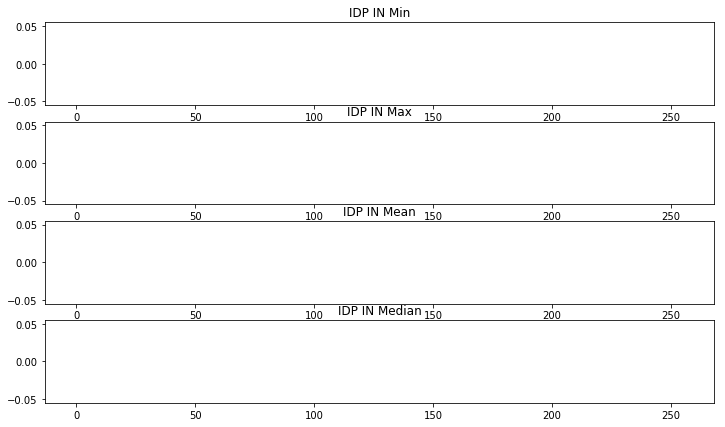

IDP OUT
IDP OUT - Min
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 2, 2, 2, 4, 0, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IDP OUT - Max
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 4, 4, 6, 7, 0, 6, 1, 3, 2, 0, 0, 0, 0, 0, 0, 

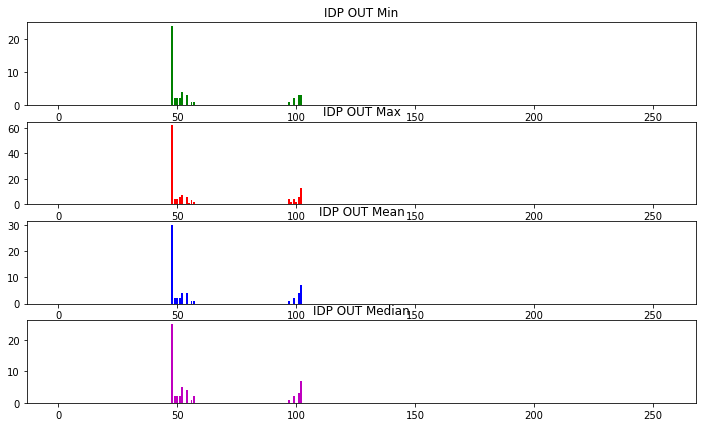

+-------------+-----+-----+-------+--------+
|     NAME    | MIN | MAX |  MEAN | MEDIAN |
+-------------+-----+-----+-------+--------+
|  IDP_LEN_in |  0  |  0  |   0   |   0    |
| IDP_LEN_out |  32 |  56 | 33.92 |   32   |
+-------------+-----+-----+-------+--------+


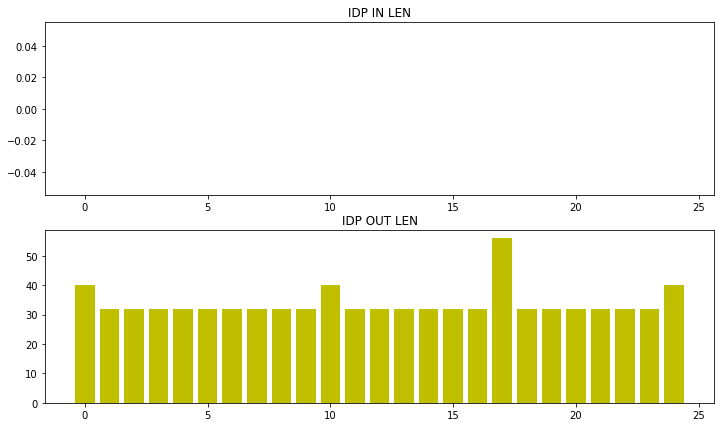

In [4]:
# IDP Feature
IDP_LEN = 1300
IDP_IN_Byte_Dist = []*256
IDP_OUT_Byte_Dist = []*256
IDP_LEN_IN = []
IDP_LEN_OUT = []
total_len = 0
total_idp_cnt = 0

for dataset in PROCESS_DATASETS:
    for root, dirs, files in os.walk(dataset):
        if dirs:
            continue
        for file in files:
            with open(root+"/"+file,encoding="utf-8", mode="r") as flows:
                for flow in flows:
                    flowData = json.loads(flow)
                    IDP_IN_Byte_Dist_Tmp = [0]*256
                    IDP_OUT_Byte_Dist_Tmp = [0]*256
                    if flowData["flow_type"] not in FIND_VALUE and ENABLE_FILTER or flowData["flow_type"] in SKIP_VALUES: # Annotated class name
                        continue
                    total_len += 1
                    
                    # Process IDP_LEN_IN
                    if "idp_len_in" in flowData: 
                        IDP_LEN_IN.append(flowData["idp_len_in"])
                        for byte in range(IDP_LEN):
                            try:
                                IDP_IN_Byte_Dist_Tmp[ord(flowData["idp_in"][byte])] += 1
                            # IDP is too short
                            except IndexError as ie:
                                continue
                    else:
                        IDP_LEN_IN.append(0)
                     
                    # Process IDP_LEN_OUT
                    if "idp_len_out" in flowData:
                        IDP_LEN_OUT.append(flowData["idp_len_out"])
                        for byte in range(IDP_LEN):
                            try:
                                IDP_OUT_Byte_Dist_Tmp[ord(flowData["idp_out"][byte])] += 1
                            # IDP is too short
                            except IndexError as ie:
                                continue
                    else:
                        IDP_LEN_OUT.append(0)
                        
                    total_idp_cnt += 1
                    IDP_IN_Byte_Dist.append(IDP_IN_Byte_Dist_Tmp)
                    IDP_OUT_Byte_Dist.append(IDP_OUT_Byte_Dist_Tmp)
                        
    IDP_IN_Byte_Dist_Min = [0]*256
    IDP_IN_Byte_Dist_Max = [0]*256
    IDP_IN_Byte_Dist_Mean = [0]*256
    IDP_IN_Byte_Dist_Median = [0]*256
    
    IDP_OUT_Byte_Dist_Min = [0]*256
    IDP_OUT_Byte_Dist_Max = [0]*256
    IDP_OUT_Byte_Dist_Mean = [0]*256
    IDP_OUT_Byte_Dist_Median = [0]*256
    
    print("DATASET:", dataset, total_len, total_idp_cnt)  
    
    # Save values for IDP_IN
    array = np.array(IDP_IN_Byte_Dist)
    for no,i in enumerate(array.T):
        IDP_IN_Byte_Dist_Min[no] = min(i)
        IDP_IN_Byte_Dist_Max[no] = max(i)
        IDP_IN_Byte_Dist_Mean[no] = mean(i)
        IDP_IN_Byte_Dist_Median[no] = median(i)
    # Save values for IDP_OUT
    array = np.array(IDP_OUT_Byte_Dist)
    for no,i in enumerate(array.T):
        IDP_OUT_Byte_Dist_Min[no] = min(i)
        IDP_OUT_Byte_Dist_Max[no] = max(i)
        IDP_OUT_Byte_Dist_Mean[no] = mean(i)
        IDP_OUT_Byte_Dist_Median[no] = median(i)
    print("IDP IN - Min")
    print(IDP_IN_Byte_Dist_Min)
    print("IDP IN - Max")
    print(IDP_IN_Byte_Dist_Max)
    print("IDP IN - Mean")
    print(IDP_IN_Byte_Dist_Mean)
    print("IDP IN - Median")
    print(IDP_IN_Byte_Dist_Median)
    
    fig5 = plt.figure(5, figsize=(12, 7))
    pl51 = fig5.add_subplot(411)
    pl51.bar(range(0,256), IDP_IN_Byte_Dist_Min,color="g")
    pl51.set_title("IDP IN Min")
    pl52 = fig5.add_subplot(412)
    pl52.bar(range(0,256), IDP_IN_Byte_Dist_Max,color="r")
    pl52.set_title("IDP IN Max")
    pl53 = fig5.add_subplot(413)
    pl53.bar(range(0,256), IDP_IN_Byte_Dist_Mean,color="b")
    pl53.set_title("IDP IN Mean")
    pl54 = fig5.add_subplot(414)
    pl54.bar(range(0,256), IDP_IN_Byte_Dist_Median,color="m")
    pl54.set_title("IDP IN Median")
    plt.show()
    
    
    print("IDP OUT")
    print("IDP OUT - Min")
    print(IDP_OUT_Byte_Dist_Min)
    print("IDP OUT - Max")
    print(IDP_OUT_Byte_Dist_Max)
    print("IDP OUT - Mean")
    print(IDP_OUT_Byte_Dist_Mean)
    print("IDP OUT - Median")
    print(IDP_OUT_Byte_Dist_Median)
    
    fig6 = plt.figure(6, figsize=(12, 7))
    pl61 = fig6.add_subplot(411)
    pl61.bar(range(0,256), IDP_OUT_Byte_Dist_Min,color="g")
    pl61.set_title("IDP OUT Min")
    pl62 = fig6.add_subplot(412)
    pl62.bar(range(0,256), IDP_OUT_Byte_Dist_Max,color="r")
    pl62.set_title("IDP OUT Max")
    pl63 = fig6.add_subplot(413)
    pl63.bar(range(0,256), IDP_OUT_Byte_Dist_Mean,color="b")
    pl63.set_title("IDP OUT Mean")
    pl64 = fig6.add_subplot(414)
    pl64.bar(range(0,256), IDP_OUT_Byte_Dist_Median,color="m")
    pl64.set_title("IDP OUT Median")
    plt.show()
    
    
    table = PrettyTable()
    table.field_names = ["NAME","MIN", "MAX", "MEAN", "MEDIAN"]
    table.add_row(["IDP_LEN_in",min(IDP_LEN_IN),max(IDP_LEN_IN),mean(IDP_LEN_IN),median(IDP_LEN_IN)])
    table.add_row(["IDP_LEN_out",min(IDP_LEN_OUT),max(IDP_LEN_OUT),mean(IDP_LEN_OUT),median(IDP_LEN_OUT)])
    print(table)
    
    fig7 = plt.figure(7, figsize=(12, 7))
    pl71 = fig7.add_subplot(211)
    pl71.bar(range(len(IDP_LEN_IN)), IDP_LEN_IN,color="y")
    pl71.set_title("IDP IN LEN")
    pl72 = fig7.add_subplot(212)
    pl72.bar(range(len(IDP_LEN_OUT)), IDP_LEN_OUT,color="y")
    pl72.set_title("IDP OUT LEN")
    plt.show()

DATASET: annotated-data-sets/voice-assistant 25


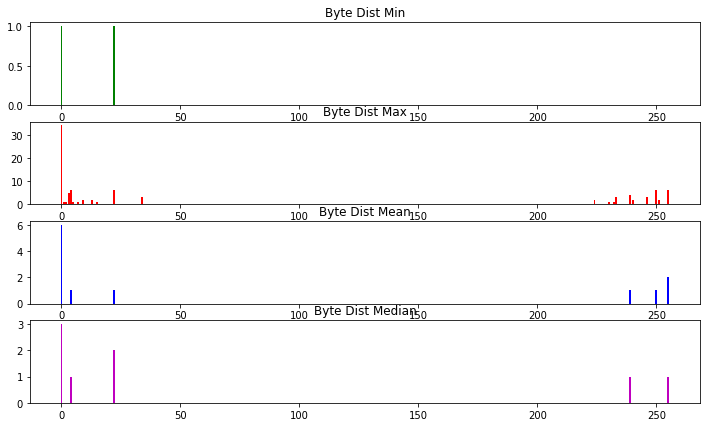

In [5]:
# Byte Distribution Feature
Byte_Dist = []*256
total_len = 0
byte_dist_cnt = 0
for dataset in PROCESS_DATASETS:
    for root, dirs, files in os.walk(dataset):
        if dirs:
            continue
        for file in files:
            with open(root+"/"+file,encoding="utf-8", mode="r") as flows:
                for flow in flows:
                    flowData = json.loads(flow)
                    Byte_Dist_Tmp = [0]*256
                    if flowData["flow_type"] not in FIND_VALUE and ENABLE_FILTER or flowData["flow_type"] in SKIP_VALUES: # Annotated class name 
                        continue
                    total_len += 1
                    if "byte_dist" in flowData:
                        Byte_Dist.append(flowData["byte_dist"])
                    else: 
                        Byte_Dist.append([0]*256)
                    
    Byte_Dist_Min = [0]*256
    Byte_Dist_Max = [0]*256
    Byte_Dist_Mean = [0]*256
    Byte_Dist_Median = [0]*256
    
    print("DATASET:", dataset, total_len)  
    array = np.array(Byte_Dist)
    # Count Byte Distribution rate for each index in all flows
    for no,i in enumerate(array.T):
        Byte_Dist_Min[no] = min(i)
        Byte_Dist_Max[no] = max(i)
        Byte_Dist_Mean[no] = mean(i)
        Byte_Dist_Median[no] = median(i)

    # Plot Byte Distribution rate
    fig8 = plt.figure(8, figsize=(12, 7))
    pl81 = fig8.add_subplot(411)
    pl81.bar(range(0,256), Byte_Dist_Min,color="g")
    pl81.set_title("Byte Dist Min")
    pl82 = fig8.add_subplot(412)
    pl82.bar(range(0,256), Byte_Dist_Max,color="r")
    pl82.set_title("Byte Dist Max")
    pl83 = fig8.add_subplot(413)
    pl83.bar(range(0,256), Byte_Dist_Mean,color="b")
    pl83.set_title("Byte Dist Mean")
    pl84 = fig8.add_subplot(414)
    pl84.bar(range(0,256), Byte_Dist_Median,color="m")
    pl84.set_title("Byte Dist Median")
    plt.show()
  

SPLT Features


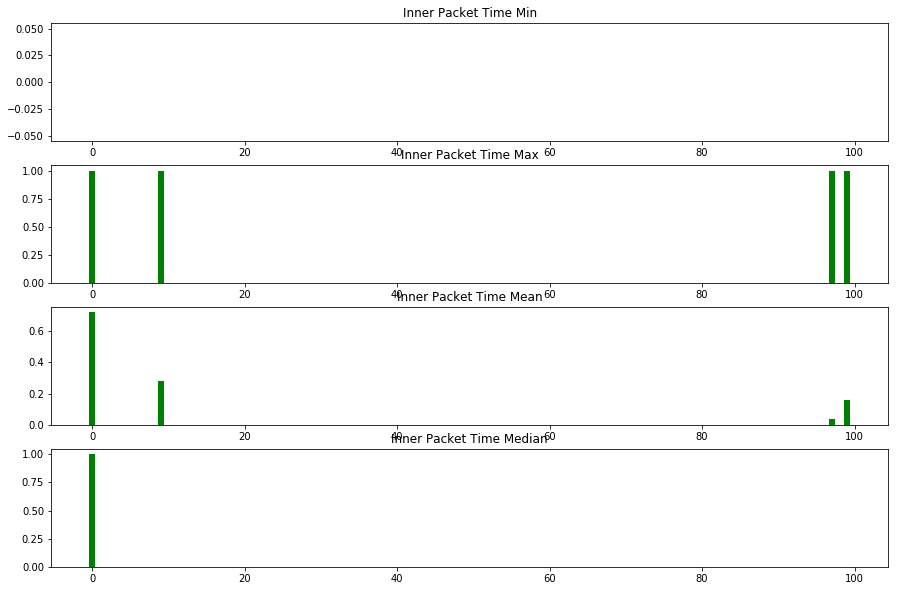

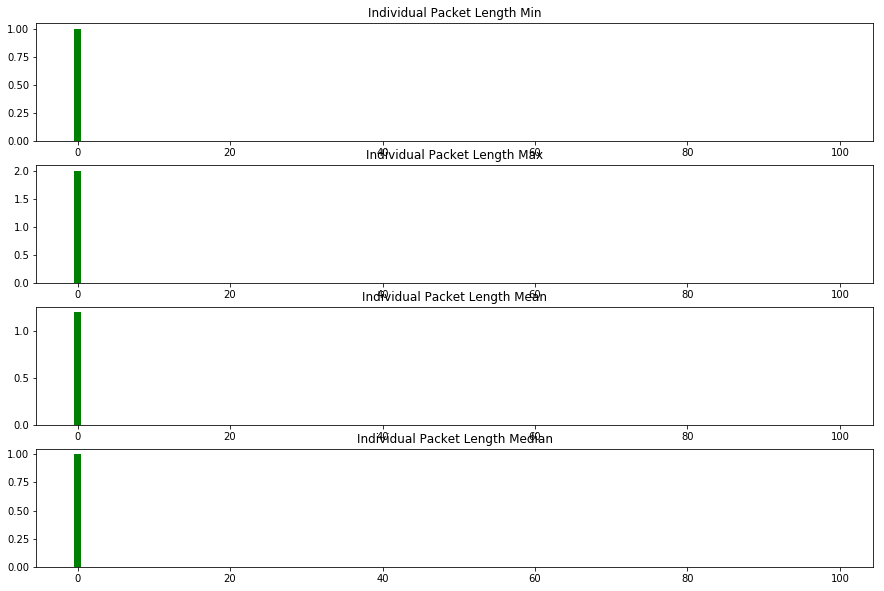

In [6]:
# SPLT Feature
FLAT_MATRIX_SIZE = 100 # This value depends on data_parser parameters (numRows,binSize) configuration
data = [] 
IPT_Data = []
PL_Data = []
for dataset in PROCESS_DATASETS:
    for root, dirs, files in os.walk(dataset):
        if dirs:
            continue
        for file in files:  
            # Count features from IPT and PL
            dParse = DataParser(root+"/"+file,analyse=1,compact=1)
            tmpIPT = dParse.getIndividualFlowIPTs()
            tmpPL = dParse.getIndividualFlowPacketLengths()
            
            # Open file with annotated date for filtering purpose
            with open(root+"/"+file,encoding="utf-8", mode="r") as flows:
                index = 0
                for flow in flows:
                    flowData = json.loads(flow)
                    if flowData["flow_type"] not in FIND_VALUE and ENABLE_FILTER or flowData["flow_type"] in SKIP_VALUES: # Annotated class name
                        index += 1
                        continue
                    # Based on flow possition select appropriate feature vector 
                    IPT_Data.append(tmpIPT[index])
                    PL_Data.append(tmpPL[index])
                    index += 1
    
    # Create list of values for plotting
    IPT_Data_Min = [0] * FLAT_MATRIX_SIZE
    IPT_Data_Max = [0] * FLAT_MATRIX_SIZE
    IPT_Data_Mean = [0] * FLAT_MATRIX_SIZE
    IPT_Data_Median = [0] * FLAT_MATRIX_SIZE
    
    PL_Data_Min = [0] * FLAT_MATRIX_SIZE
    PL_Data_Max = [0] * FLAT_MATRIX_SIZE
    PL_Data_Mean = [0] * FLAT_MATRIX_SIZE
    PL_Data_Median = [0] * FLAT_MATRIX_SIZE
    
    # Count IPT rate for each index in all flows
    tmp_array = np.array(IPT_Data)
    for no,i in enumerate(tmp_array.T):
        IPT_Data_Min[no] = min(i)
        IPT_Data_Max[no] = max(i)
        IPT_Data_Mean[no] = mean(i)
        IPT_Data_Median[no] = median(i)
    
    # Count PL rate for each index in all flows
    tmp_array = np.array(PL_Data)
    for no,i in enumerate(tmp_array.T):
        PL_Data_Min[no] = min(i)
        PL_Data_Max[no] = max(i)
        PL_Data_Mean[no] = mean(i)
        PL_Data_Median[no] = median(i)
    
    print("SPLT Features")
    # Plot Packet Lengths rate
    fig9 = plt.figure(9, figsize=(15, 10))
    pl91 = fig9.add_subplot(411)
    pl91.bar(range(len(IPT_Data_Min)), IPT_Data_Min,color="g")
    pl91.set_title("Inner Packet Time Min") 
    pl92 = fig9.add_subplot(412)
    pl92.bar(range(len(IPT_Data_Max)), IPT_Data_Max,color="g")
    pl92.set_title("Inner Packet Time Max")
    pl93 = fig9.add_subplot(413)
    pl93.bar(range(len(IPT_Data_Mean)), IPT_Data_Mean,color="g")
    pl93.set_title("Inner Packet Time Mean")
    pl94 = fig9.add_subplot(414)
    pl94.bar(range(len(IPT_Data_Median)), IPT_Data_Median,color="g")
    pl94.set_title("Inner Packet Time Median")
    plt.show()
    
    # Plot Packet Lengths rate
    fig10 = plt.figure(10, figsize=(15, 10))
    pl101 = fig10.add_subplot(411)
    pl101.bar(range(len(PL_Data_Min)), PL_Data_Min,color="g")
    pl101.set_title("Individual Packet Length Min") 
    pl102 = fig10.add_subplot(412)
    pl102.bar(range(len(PL_Data_Max)), PL_Data_Max,color="g")
    pl102.set_title("Individual Packet Length Max")
    pl103 = fig10.add_subplot(413)
    pl103.bar(range(len(PL_Data_Mean)), PL_Data_Mean,color="g")
    pl103.set_title("Individual Packet Length Mean")
    pl104 = fig10.add_subplot(414)
    pl104.bar(range(len(PL_Data_Median)), PL_Data_Median,color="g")
    pl104.set_title("Individual Packet Length Median")
    plt.show()
    
    